In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import norm
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import KernelDensity
from pykalman import KalmanFilter
from utils import find_cointegrated_pairs, trading, plot_trading_result

In [3]:
# load time series
AUD = pd.read_csv("../data/AUD.csv")
EUR = pd.read_csv("../data/EUR.csv")
GBP = pd.read_csv("../data/GBP.csv")
NZD = pd.read_csv("../data/NZD.csv")

In [4]:
NZD.head()

Date   Price
0  32874  0.5955
1  32875  0.5962
2  32876  0.5958
3  32877  0.6002
4  32878  0.5995

In [5]:
df = AUD.merge(EUR,on='Date').merge(GBP,on='Date').merge(NZD,on='Date')
df.columns = ["Date", "AUD", "EUR", "GBP", "NZD"]

In [6]:
prices_df = df[["AUD", "EUR", "GBP", "NZD"]]

# Pairs selection & Cointegration test

In [7]:
pvalues, pairs = find_cointegrated_pairs(prices_df)

In [8]:
stock_list = ["AUD", "EUR", "GBP", "NZD"]

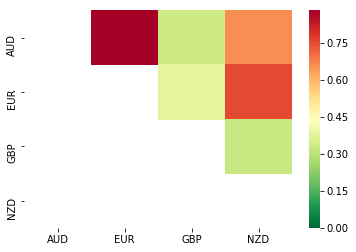

In [9]:
sns.heatmap(1-pvalues, xticklabels=stock_list, yticklabels=stock_list, cmap='RdYlGn_r', mask = (pvalues == 1))
plt.show()

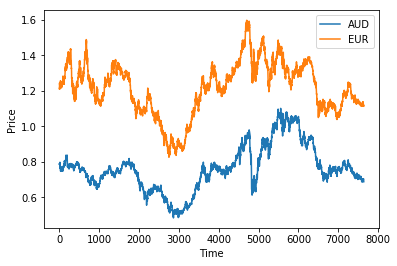

In [10]:
stock_df1 = prices_df["AUD"]
stock_df2 = prices_df["EUR"]
plt.plot(stock_df1)
plt.plot(stock_df2)
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend(["AUD", "EUR"],loc='best')
plt.show()

In [11]:
val_num = int(len(stock_df1)*0.2)

In [12]:
X = np.array(stock_df1[:-val_num]).reshape(-1,1)
y = np.array(stock_df2[:-val_num])
reg = LinearRegression().fit(X, y)
gamma = reg.coef_
u = reg.intercept_
print("r square:", reg.score(X, y))
print("gamma:{}".format(gamma))
print("mu:{}".format(u))

r square: 0.6061682503217742
gamma:[0.88447521]
mu:0.5537102762407347


In [13]:
# method2 for regression
x = stock_df1
y = stock_df2
X = sm.add_constant(x)
result = (sm.OLS(y,X)).fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                    EUR   R-squared:                       0.590
Model:                            OLS   Adj. R-squared:                  0.590
Method:                 Least Squares   F-statistic:                 1.100e+04
Date:                Tue, 13 Aug 2019   Prob (F-statistic):               0.00
Time:                        12:33:59   Log-Likelihood:                 7095.9
No. Observations:                7643   AIC:                        -1.419e+04
Df Residuals:                    7641   BIC:                        -1.417e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5384      0.007     82.303      0.0

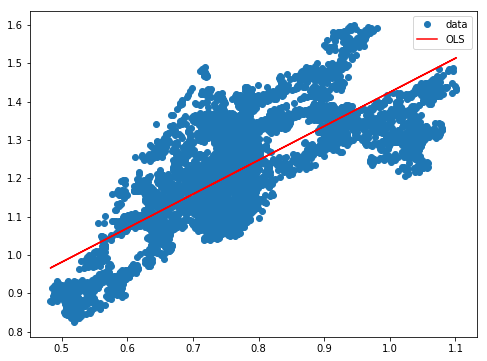

In [14]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(x, y, 'o', label="data")
ax.plot(x, result.fittedvalues, 'r', label="OLS")
ax.legend(loc='best')
plt.show()

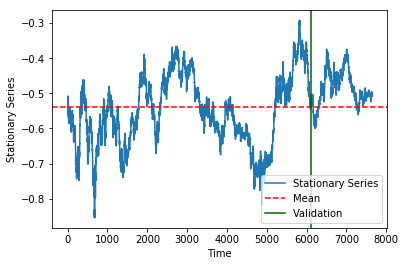

In [15]:
plt.plot(gamma*stock_df1-stock_df2);
plt.axhline((gamma*stock_df1-stock_df2).mean(), color="red", linestyle="--")
plt.axvline(x=len(stock_df1)-val_num,color="darkgreen")
plt.xlabel("Time"); plt.ylabel("Stationary Series")
plt.legend(["Stationary Series", "Mean","Validation"], loc="best")
plt.show()

# tests for the stationarity of $\hat{\epsilon_t}$ (Augmented Dickey-Fuller test)

In [16]:
e = prices_df["EUR"] - prices_df["AUD"]*gamma+u

In [17]:
result = adfuller(e)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.251703
p-value: 0.017180
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


# Trading strategy design - baseline

In [18]:
z = prices_df["EUR"] - prices_df["AUD"]*gamma

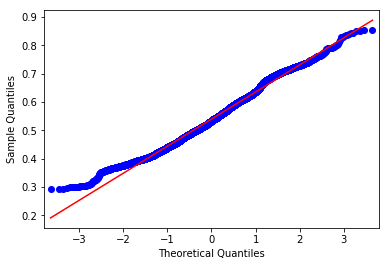

In [19]:
# spread normal dist.?
qqplot(z, line='s')
plt.show()

### z-score method (standard normalizatoin)

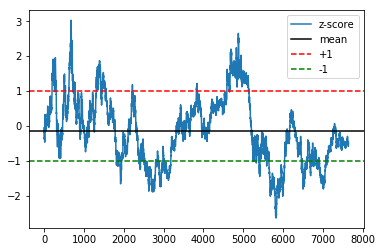

In [20]:
# z normalization using train mean and std
train_mean = np.mean(z[:-val_num])
train_std = np.std(z[:-val_num])
z_zscore = (z-train_mean)/train_std

plt.plot(z_zscore)
plt.axhline(z_zscore.mean(), color="black")
plt.axhline(1.0, color="red", linestyle="--")
plt.axhline(-1.0, color="green", linestyle="--")
plt.legend(["z-score", "mean", "+1", "-1"])
plt.show()

Total profit = profit of each trade × number of trades
* profit of each trade is $s_0$
* number of trades is related to the zero crossings, which can be analyzed theoretically as well as empirically.

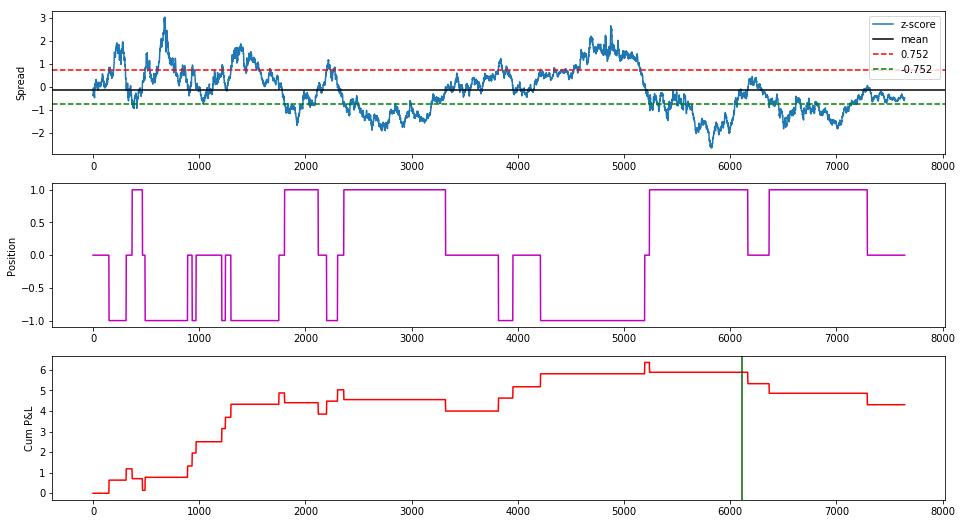

cumulative profit: 4.30460953539126


In [21]:
S = np.arange(0.0, 3.0, 0.001)
prob = 1-norm.cdf(S, scale=1)
total_profit = S*(len(prices_df["EUR"])-val_num)*(1-norm.cdf(S)) # use standard normal
s0 = S[np.argmax(total_profit)]

spread = -prices_df["EUR"] + prices_df["AUD"]*gamma

position, profit, cum_profit = trading(z_zscore, s0, spread)
plot_trading_result(z_zscore, position, profit, s0, val_num)

print("cumulative profit:", cum_profit)

The problem with the LS regression is that it assumes that $\mu$ and $\gamma$ are constant.

### Optimum threshold $s_0$: Parametric approach

In [22]:
# the number of tradable events = T*(1-phi(s0))
# total profit = s0*T*(1-phi(s0))

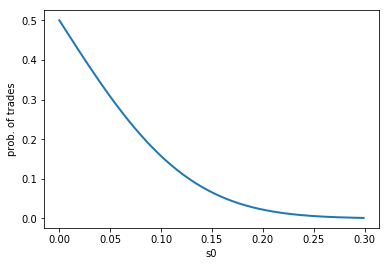

In [23]:
dist = GaussianMixture()
dist.fit(np.array(z[:-val_num]).reshape(-1,1))
S = np.arange(0.0, 0.3, 0.001)
prob = 1-norm.cdf(S, scale=dist.covariances_[0][0][0]**0.5)
line, = plt.plot(S, prob, lw=2)
plt.ylabel("prob. of trades")
plt.xlabel("s0")
plt.show()

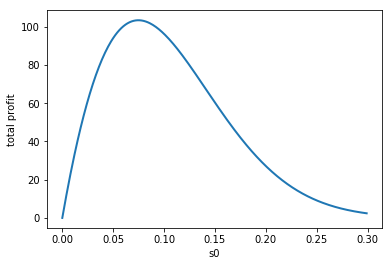

In [24]:
total_profit = S*(len(prices_df["EUR"])-val_num)*(prob)
line, = plt.plot(S, total_profit, lw=2)
plt.xlabel("s0")
plt.ylabel("total profit")
plt.show()

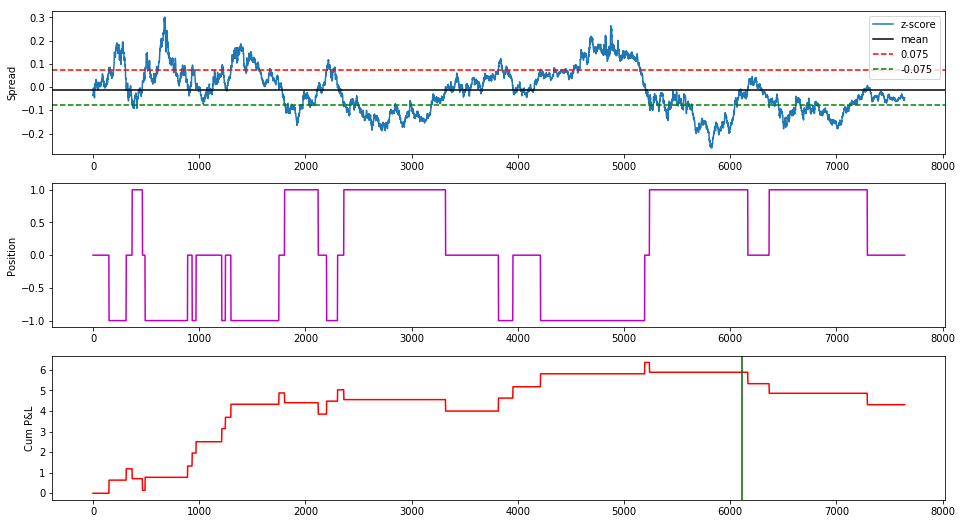

cumulative profit: 4.30460953539126


In [25]:
dist = GaussianMixture()
dist.fit(np.array(z[:-val_num]).reshape(-1,1))
S = np.arange(0.0, 3., 0.001)
prob = 1-norm.cdf(S, scale=dist.covariances_[0][0][0]**0.5)
total_profit = S*(len(prices_df["EUR"])-val_num)*(prob)
s0 = S[np.argmax(total_profit)]

spread = -prices_df["EUR"] + prices_df["AUD"]*gamma
z_zero_mean = z-u

position, profit, cum_profit = trading(z_zero_mean, s0, spread)

plot_trading_result(z_zero_mean, position, profit, s0, val_num)

print("cumulative profit:", cum_profit)

# Kalman for pairs trading

In [ ]:
observation_matrices = np.expand_dims(np.vstack([[prices_df["AUD"]], [np.ones(len(prices_df["AUD"]))]]).T, axis=1)
observation_matrices.shape

In [ ]:
transition_matrices = [[1, 0], [0, 1]]
observation_matrices = np.expand_dims(np.vstack([[np.ones(len(prices_df["AUD"]))], [prices_df["AUD"]], ]).T, axis=1)
np.random.seed(0)
kf = KalmanFilter(transition_matrices = transition_matrices, observation_matrices = observation_matrices[:-val_num])
kf.em(prices_df["EUR"][:-val_num])
filter_mean,filter_cov = kf.filter(prices_df["EUR"][:-val_num])

In [ ]:
for i in range(len(stock_df1)-val_num, len(stock_df1)):
    observation_matrix = observation_matrices[i]
    observation = prices_df["EUR"][i]
    
    next_filter_mean,next_filter_cov = kf.filter_update(
            filtered_state_mean = filter_mean[-1],
            filtered_state_covariance = filter_cov[-1],
            observation = observation,
            observation_matrix = observation_matrix)

    filter_mean = np.vstack((filter_mean,next_filter_mean))
    filter_cov = np.vstack((filter_cov,next_filter_cov.reshape(1,2,2)))

In [ ]:
kf_gammas = filter_mean[:,0]
kf_us = filter_mean[:,1]

In [ ]:
s0 = 0.752

train_mean = np.mean(z[:-val_num])
train_std = np.std(z[:-val_num])
z_zscore_kf = (z-kf_us)/train_std

spread = -prices_df["EUR"] + prices_df["AUD"]*kf_gammas
profit = [0]*len(z_zscore)
cum_profit = 0
position = [0]*len(z_zscore)
cur_pos = 0

for i in range(1, len(z_zscore)):
    
    if z_zscore_kf[i]<-s0 and cur_pos==0:
        # buy spread
        cum_profit += spread[i]
        cur_pos = 1
    if z_zscore_kf[i]>s0 and cur_pos==0:
        # short-sell spread
        cum_profit -= spread[i]
        cur_pos = -1
    if z_zscore_kf[i]*z_zscore_kf[i-1]<0 and cur_pos==-1: # zero-crossing
        cum_profit -= spread[i]
        cur_pos = 0
    if z_zscore_kf[i]*z_zscore_kf[i-1]<0 and cur_pos==1:
        cum_profit += spread[i]
        cur_pos = 0
        
    profit[i] = cum_profit
    position[i] = cur_pos

plt.figure(figsize=(16,9))
plt.subplot(3,1,1)
plt.plot(z_zscore_kf)
plt.axhline(z_zscore_kf.mean(), color="black")
plt.axhline(s0, color="red", linestyle="--")
plt.axhline(-s0, color="green", linestyle="--")
plt.legend(["z-score", "mean", "{}".format(s0), "{}".format(-s0)])
plt.ylabel("Spread")

plt.subplot(3,1,2)
plt.plot(position, "m")
plt.ylabel("Position")

plt.subplot(3,1,3)
plt.axvline(x=len(stock_df1)-val_num,color="darkgreen")
plt.plot(profit, "r")
plt.ylabel("Cum P&L")
plt.show()
print("cumulative profit:", cum_profit)